In [5]:
#!/usr/bin/env python
import cv2
import numpy as np 
import matplotlib.pyplot as plt


def find_yellow_lanes(bgr_img):
    hls_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)

    lower_yellow = np.array([10, 30, 90])
    upper_yellow = np.array([40, 220, 255])

    yellow_filter = cv2.inRange(hls_img, lower_yellow, upper_yellow)
    yellow_filtered_img = cv2.bitwise_and(bgr_img, bgr_img, mask=yellow_filter)
    
    return yellow_filtered_img

def find_n_largest_contours(bgr_img, n=2):
    # find contours
    img = bgr_img.copy()
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, h = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # sort contours by size
    area_array = []
    for i,c in enumerate(contours):
        area = cv2.contourArea(c)
        area_array.append(area)
    sorted_contours = sorted(zip(area_array, contours), key=lambda x:x[0], reverse=True)
    my_contours = []
    
    # top n size contours
    for i in range(n):
        try:
            my_contours.append(sorted_contours[i][1])
        except IndexError:
            break
    cv2.drawContours(img, my_contours, -1, (0,255,0))

    contour_centroids = []
    excepted = False
    # find center of top n size contours
    for c in my_contours:
        # center of the contour
        M = cv2.moments(c)
        try:
            # cX:row, cY:col, top_left: [0,0]
            cY = int(M["m10"] / M["m00"])
            cX = int(M["m01"] / M["m00"])
        except:
            excepted=True
        # draw the contour and center of the shape on the image
        if excepted:
            cX = int(img.shape[0]*0.7)
            cY = int(img.shape[1]*0.5)
        
        cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
        cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)
        contour_centroids.append((cX, cY))
        
    # find second lowest positioned contour 
    sorted_centroids = sorted(contour_centroids, key=lambda tup: tup[0], reverse=True)
    
    if len(sorted_centroids)==0:
        cX = int(img.shape[0]*0.7)
        cY = int(img.shape[1]*0.5)
        cv2.circle(img, (cY, cX), 7, (255, 0, 0), -1)

    elif len(sorted_centroids)==1:
        cY, cX = sorted_centroids[0]
    else:
        cY, cX = sorted_centroids[1]
        
    return img, (cX, cY)

In [29]:
bgr_img = cv2.imread('img_19.jpg')

In [4]:
hls_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)


In [6]:
r = find_yellow_lanes(bgr_img)
cv2.imshow('image',r)
plt.show()


In [7]:
img = bgr_img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
cv2.imshow('image', imgray)
cv2.waitKey(0)

0

In [9]:
contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# RETR_TREE is the retrieval mode
# CHAIN_APRROX_NONE is the contour approximation

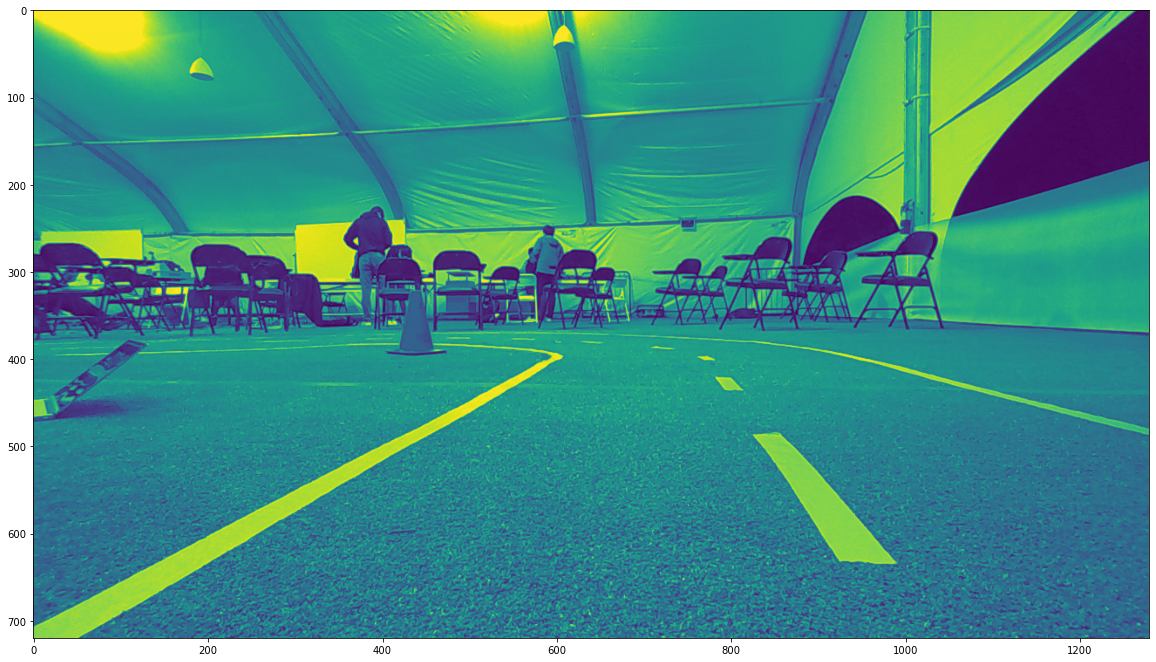

In [10]:
#cv2.imshow('image', imgray)
plt.figure(figsize=(20,20))
plt.imshow(img)

In [ ]:
cv2.imshow('image', imgray)
cv2.waitKey(0)

In [11]:
area_array = []
for i,c in enumerate(contours):
    area = cv2.contourArea(c)
    area_array.append(area)
sorted_contours = sorted(zip(area_array, contours), key=lambda x:x[0], reverse=True)
my_contours = []
    

In [13]:
area_array

[919600.5,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 4.0,
 2.0,
 4.0,
 4.0,
 4.0,
 6.0,
 2.0,
 2.0,
 6.0,
 6.0,
 2.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 6.0,
 6.0,
 2.0,
 2.0,
 2.0]

In [22]:
for i in range(2):
    try:
        my_contours.append(sorted_contours[i][1])
    except IndexError:
        break
cv2.drawContours(img, my_contours, -1, (0,255,0))

contour_centroids = []
excepted = False

In [25]:
for c in my_contours:
    # center of the contour
    M = cv2.moments(c)
    try:
        # cX:row, cY:col, top_left: [0,0]
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
    except:
        excepted=True
    # draw the contour and center of the shape on the image
    if excepted:
        cX = int(img.shape[0]*0.7)
        cY = int(img.shape[1]*0.5)

    t = cv2.drawContours(img, [c], -1, (0, 255, 0), 2)
    cv2.circle(t, (cY, cX), 7, (255, 0, 0), -1)
    contour_centroids.append((cX, cY))


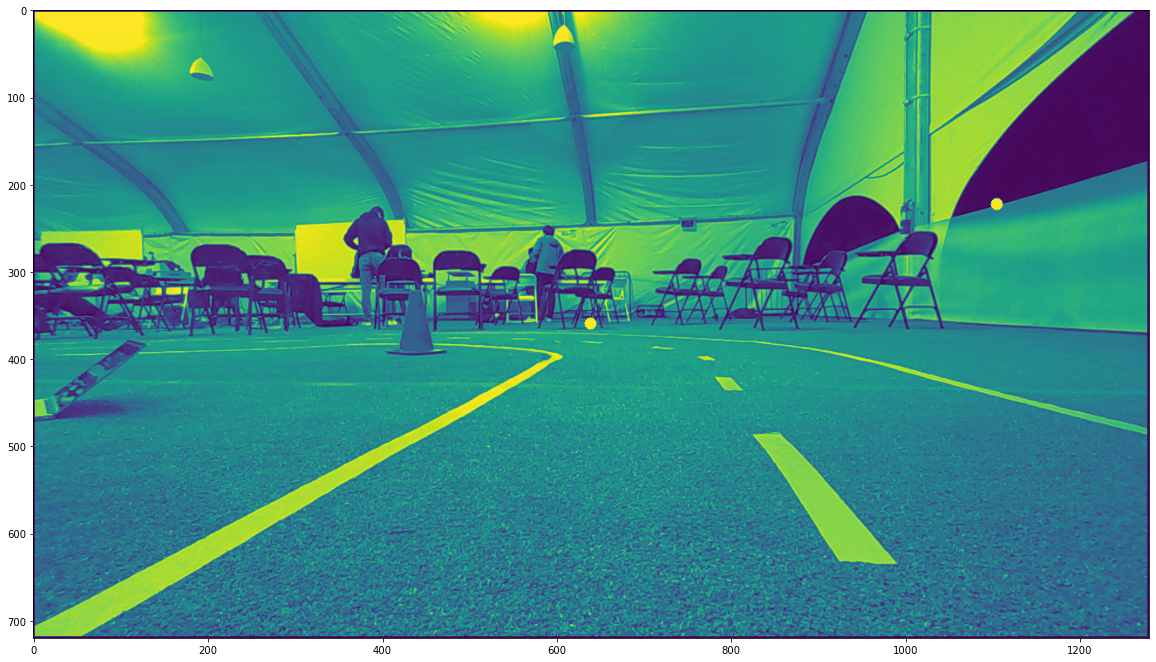

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(t)

In [32]:
tt, other = find_n_largest_contours(bgr_img)

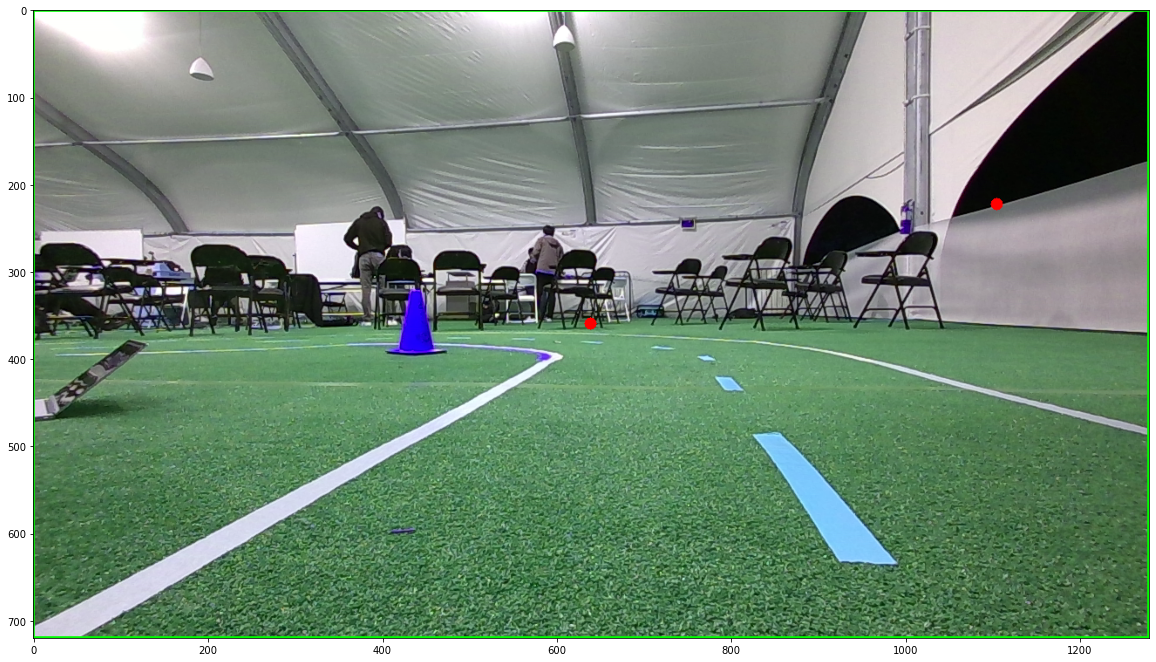

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(tt)

In [40]:
#!/usr/bin/env python

import sys
import cv2
import numpy as np

import lane_utils

from datetime import datetime

class follow_centroid(object):
    def __init__(self):
        self.bridge_object = CvBridge()
        self.image_sub = rospy.Subscriber("/camera/color/image_raw", Image, self.camera_callback)
        self.drivecar_object = drive_car()
        self.temp_time = datetime.now()

    def camera_callback(self, data):
        start = datetime.now()
        try:
            cv_image = self.bridge_object.imgmsg_to_cv2(data, desired_encoding="bgr8")
        except CvBridgeError as e:
            print(e)
            
        h = cv_image.shape[0]
        w = cv_image.shape[1]

        cropped_bgr_img = cv_image[int(h*0.5):, int(w*0.2):int(w*0.8)]
        lane_img = lane_utils.find_yellow_lanes(cropped_bgr_img)
        centroid_img, (cX, cY) = lane_utils.find_n_largest_contours(lane_img)
        cv2.imshow("Image", cropped_bgr_img)
        cv2.imshow("Centroid", centroid_img)
        cv2.waitKey(1)
        
        h = cropped_bgr_img.shape[0]
        w = cropped_bgr_img.shape[1]

        # if cX > h*0.6:
        #     my_steering_angle = -np.arctan(cY-w/0.3)
        #     temp_percent = cX/h
        # elif cX > h*0.45:
        #     my_steering_angle = -np.arctan((cY-w/2)/2)

        if cX > w/2:
            my_steering_angle = -0.7#-np.arctan((cY-w/2) / (h-cX+1e-20))
        else:
            my_steering_angle = 0.7

        acker_object = AckermannDriveStamped()
        acker_object.drive.steering_angle = my_steering_angle
        print(cY, w/2)
        acker_object.drive.steering_angle_velocity = my_steering_angle/200
        acker_object.drive.speed = 0.5


        self.drivecar_object.move_robot(acker_object)


class drive_car(object):
    def __init__(self):
        self.cmd_vel_pub = rospy.Publisher('/vesc/low_level/ackermann_cmd_mux/output', AckermannDriveStamped, queue_size=1)
        self.last_cmdvel_command = AckermannDriveStamped()

    def move_robot(self, acker_object):
        self.cmd_vel_pub.publish(acker_object)
    
    def reset_robot(self):
        return


def main():
    line_follower_object = follow_centroid()
    rospy.init_node("line_following_node")
    try:
        rospy.spin()
    except KeyboardInterrupt:
        print("Shutting Down")
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

NameError: name 'CvBridge' is not defined